In [1]:
import requests
from datetime import datetime, timezone, timedelta
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
# Gloabl seaborn Theme
sns.set_theme(style="whitegrid", palette="pastel")
import math
import import_ipynb
from evaluation import to_timestamp, request_influxdb, query_data, histplots, boxplots, lineplots, evaluate_sensors


importing Jupyter notebook from evaluation.ipynb


In [2]:
# Load Tangaras
tangaras = pd.read_csv('../data/tangaras.csv')
tangaras.shape

(22, 7)

In [3]:
# Start Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
#start_timestamp = to_timestamp('2023-03-17T00:00:00-05:00')
start_timestamp = to_timestamp('2023-04-03T00:00:00-05:00')
# End Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
#end_timestamp = to_timestamp('2023-03-31T00:00:00-05:00')
end_timestamp = to_timestamp('2023-04-04T00:00:00-05:00')

print(f'Since: {start_timestamp} Until: {end_timestamp}')


Since: 1680498000000 Until: 1680584400000


In [4]:
# Query Data Sensors
query = query_data(tangaras, start_timestamp, end_timestamp, datatype='hum')
print(query)

SELECT "name", last("hum") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE0DD66') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("hum") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE0E752') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("hum") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE1260A') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("hum") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE94B1A') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("hum") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE965F2') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("hum") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DEBD89A') AND time >= 1680498000000ms AND time <= 168

In [5]:
# Get Data Frame Sensors
def df_sensors(tangaras, start_timestamp, end_timestamp):
    # Data Frame Sensors
    df_sensors = []
    # SQL Query Data Sensors
    query = query_data(tangaras, start_timestamp, end_timestamp, datatype='hum')
    # InfluxDB API REST Request
    influxdb_request = request_influxdb(query)
    #print(influxdb_request)
    #print(influxdb_request.text)

    # Data Frame InfluxDB Sensors
    df_influxdb_sensors = pd.read_csv(StringIO(influxdb_request.text), sep=",", low_memory=False)

    # Remove/Add Columns
    df_influxdb_sensors = df_influxdb_sensors[['time', 'name.1', 'last']]
    df_influxdb_sensors.rename(columns={'time': 'DATETIME', 'name.1': 'MAC', 'last': 'HUM'}, inplace=True)

    # Truncate Response
    for index, row in tangaras.iterrows():
        df_sensor = df_influxdb_sensors.loc[df_influxdb_sensors['MAC'] == row['MAC']].reset_index(drop=True)[['DATETIME', 'HUM']] # Warning
        if not df_sensor.empty:
            df_sensor.rename(columns={'HUM': row['ID']}, inplace=True)
            df_sensor.set_index('DATETIME', inplace=True)
            df_sensors.append(df_sensor)
    
    df_sensors = df_sensors[0].join(df_sensors[1:]).reset_index()

    # Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
    tz = timezone(timedelta(hours=-5))
    df_sensors['DATETIME'] = df_sensors['DATETIME'].apply(lambda x: datetime.fromtimestamp(int(x) / 1000, tz=tz).isoformat())

    df_sensors[df_sensors.columns.to_list()[1:]] = df_sensors[df_sensors.columns.to_list()[1:]].astype('float64')
    
    return df_sensors


In [6]:
# Data Frame Sensors
hum_raw = df_sensors(tangaras, start_timestamp, end_timestamp)
hum_raw.head()

,DATETIME,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
0,2023-04-03T00:00:00-05:00,0.0,77.31,73.86,71.17,69.86,74.61,67.54,NaN,NaN,...,59.73,65.54,NaN,73.77,NaN,69.97,75.09,NaN,63.02,NaN
1,2023-04-03T00:00:30-05:00,0.0,76.51,NaN,70.85,70.26,74.27,67.08,60.03,57.50,...,59.75,65.57,56.94,73.72,62.10,NaN,NaN,98.5,63.02,67.05
2,2023-04-03T00:01:00-05:00,0.0,76.77,74.20,70.80,NaN,74.00,66.93,59.97,57.48,...,59.86,65.59,57.04,73.71,62.37,69.26,74.47,98.5,62.95,67.12
3,2023-04-03T00:01:30-05:00,0.0,76.90,74.28,70.87,70.14,74.17,67.18,60.11,57.53,...,59.96,65.64,56.78,73.69,62.43,69.53,74.69,98.5,62.86,67.03
4,2023-04-03T00:02:00-05:00,0.0,77.07,74.28,70.85,70.32,74.21,67.02,60.09,57.53,...,60.06,65.68,57.25,73.70,62.21,69.65,74.92,98.5,62.67,67.00


# Descriptive Statistics

In [7]:
# Describe Data
hum_raw.describe()

,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,TANGARA_1A1E,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
count,2667.0,2582.000000,2561.000000,2574.000000,2566.000000,2577.000000,2569.000000,2654.000000,2612.000000,2178.000000,...,2628.000000,2554.000000,2648.000000,2662.000000,2602.000000,2583.000000,2579.000000,2641.000000,2638.000000,2634.000000
mean,0.0,63.210236,67.272132,59.002956,64.613562,64.093143,59.638478,55.477762,54.044989,54.065978,...,55.471701,60.689933,54.015340,62.617926,55.688125,58.120178,62.471272,92.557554,57.528415,57.024613
std,0.0,11.448361,6.349614,10.569407,5.748522,10.149684,7.945805,9.458395,6.874283,11.655410,...,10.505114,6.420083,4.722728,9.957468,13.979478,9.474068,10.743353,7.714896,8.830253,9.379495
min,0.0,41.310000,51.360000,39.470000,49.720000,42.920000,41.810000,35.550000,43.290000,33.550000,...,41.620000,42.050000,42.120000,45.100000,32.160000,39.210000,41.720000,76.500000,42.700000,42.160000
25%,0.0,54.382500,62.990000,50.732500,61.852500,56.720000,53.460000,47.860000,47.377500,42.712500,...,45.260000,55.542500,51.477500,53.775000,44.267500,51.035000,53.945000,87.400000,48.990000,48.480000
50%,0.0,62.880000,68.190000,58.000000,65.125000,64.800000,60.400000,55.665000,53.415000,54.905000,...,52.740000,61.160000,56.420000,61.360000,53.930000,57.350000,60.570000,93.800000,57.550000,54.780000
75%,0.0,76.340000,73.710000,71.330000,69.950000,74.630000,67.640000,64.070000,60.860000,65.960000,...,66.870000,66.630000,57.320000,73.770000,70.400000,68.955000,74.990000,99.900000,66.707500,67.460000
max,0.0,78.410000,75.260000,72.780000,71.350000,76.780000,69.430000,70.880000,63.660000,70.910000,...,72.800000,68.770000,62.530000,77.110000,77.300000,71.280000,77.330000,99.900000,70.610000,72.280000


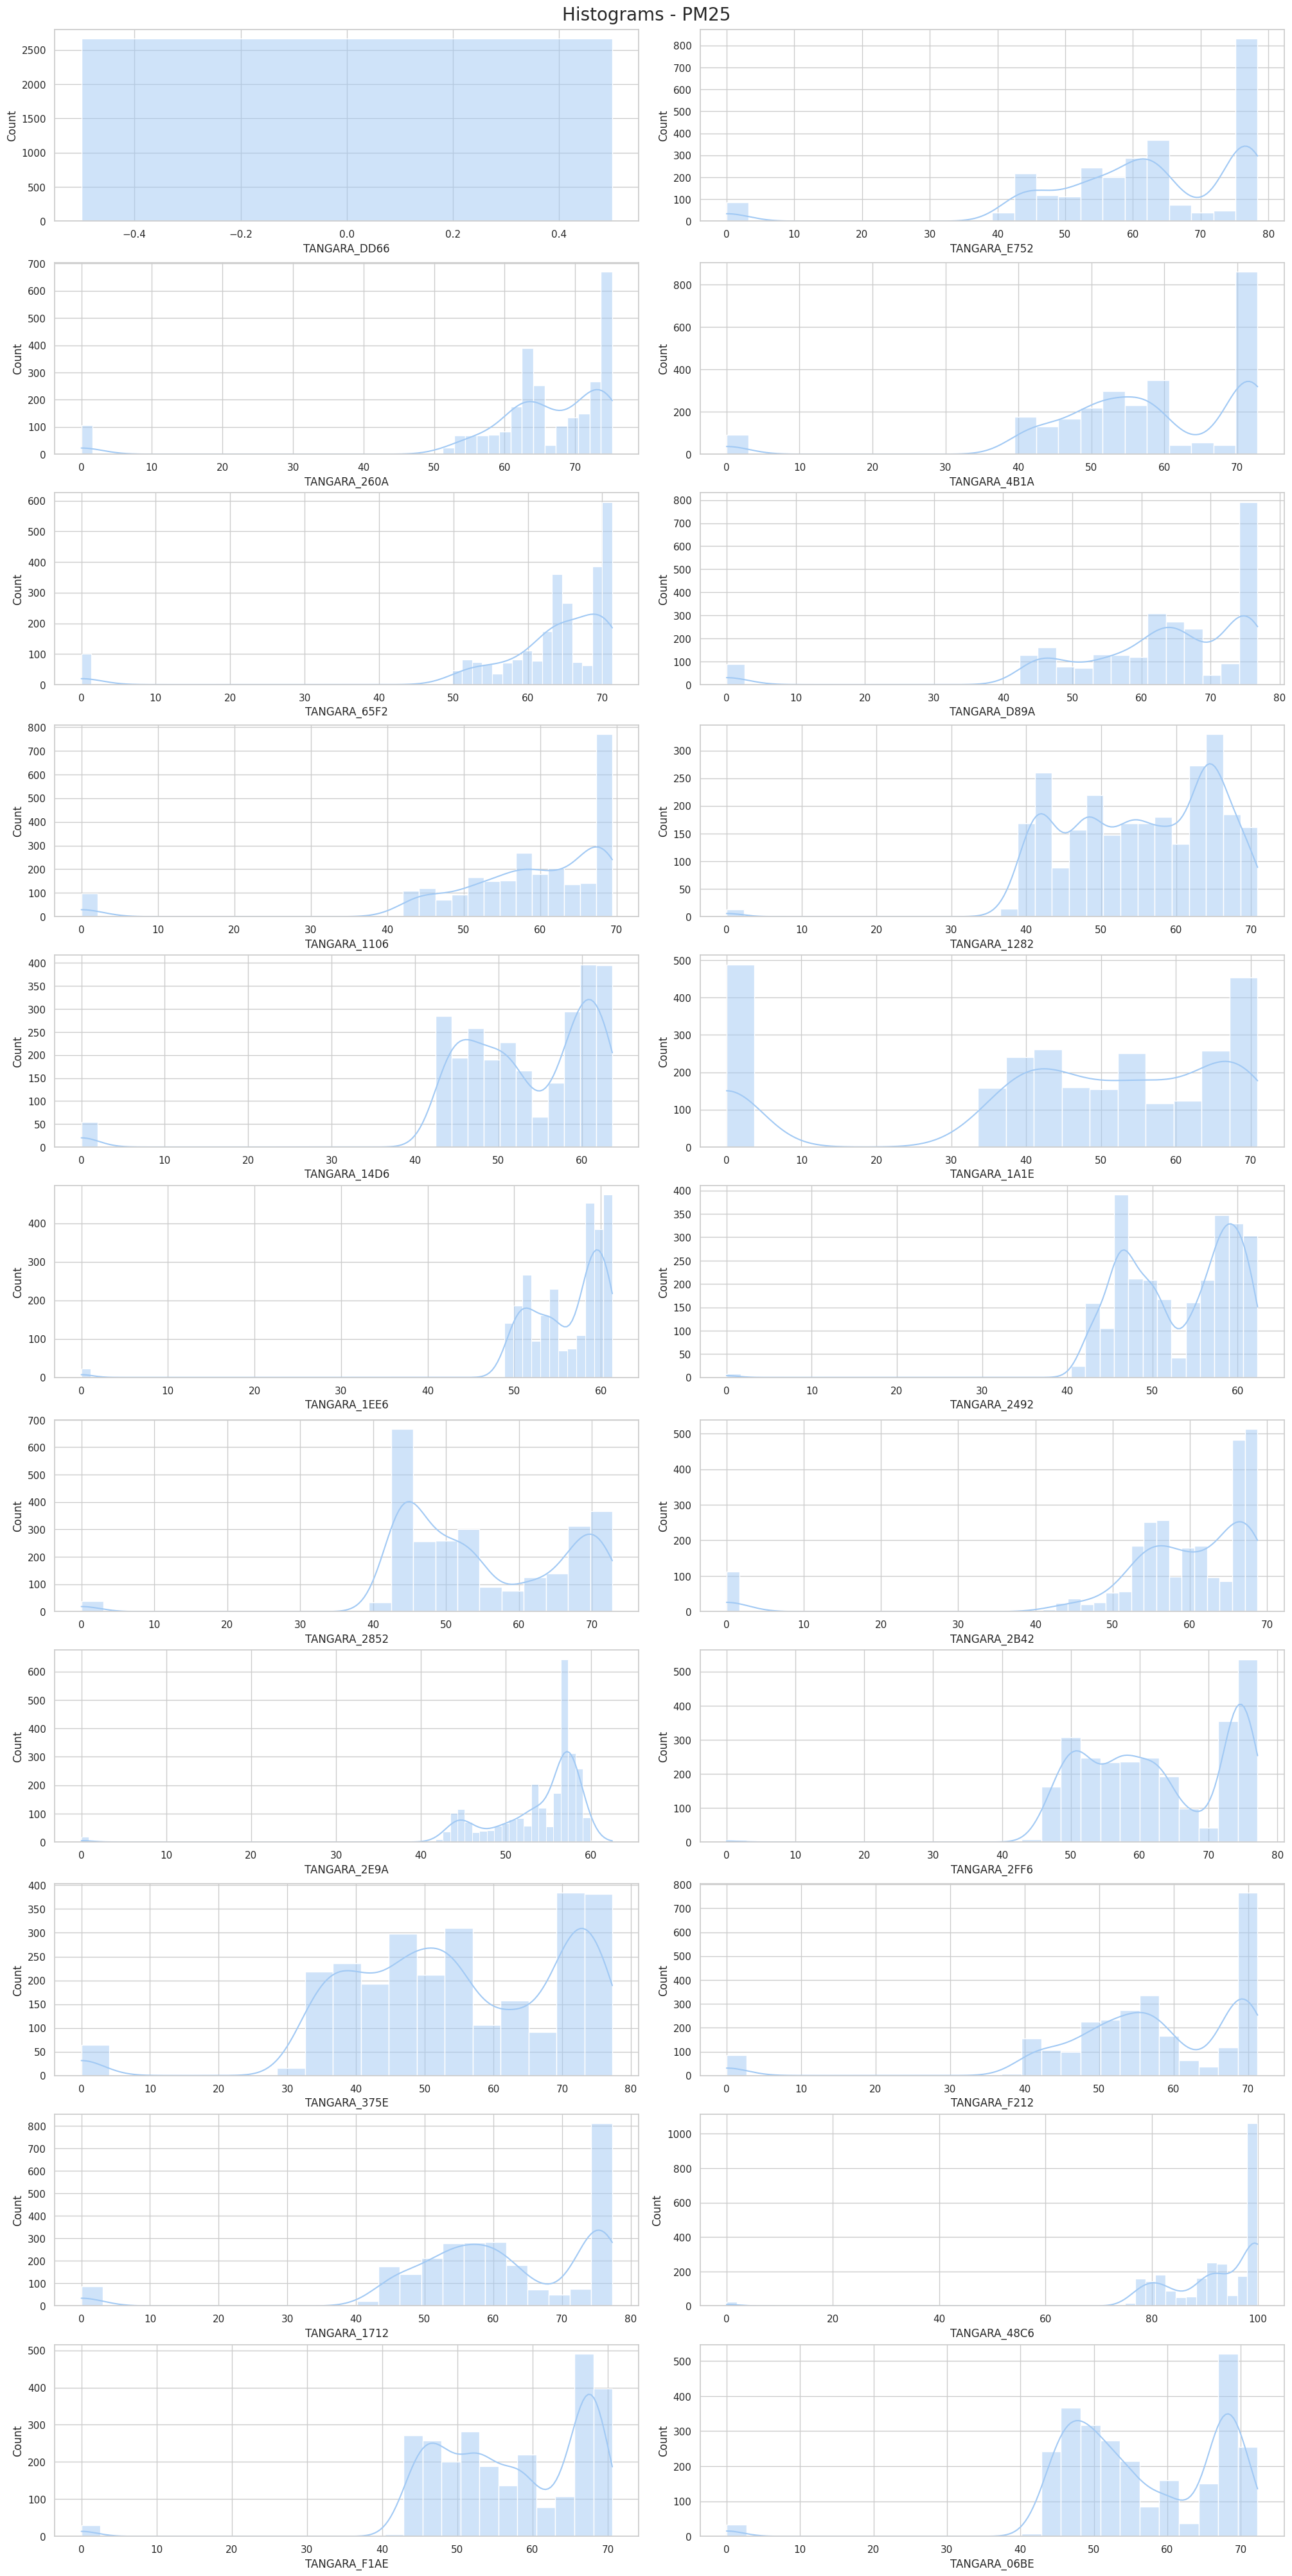

In [8]:
# Plot Humidity Histograms
histplots(hum_raw)

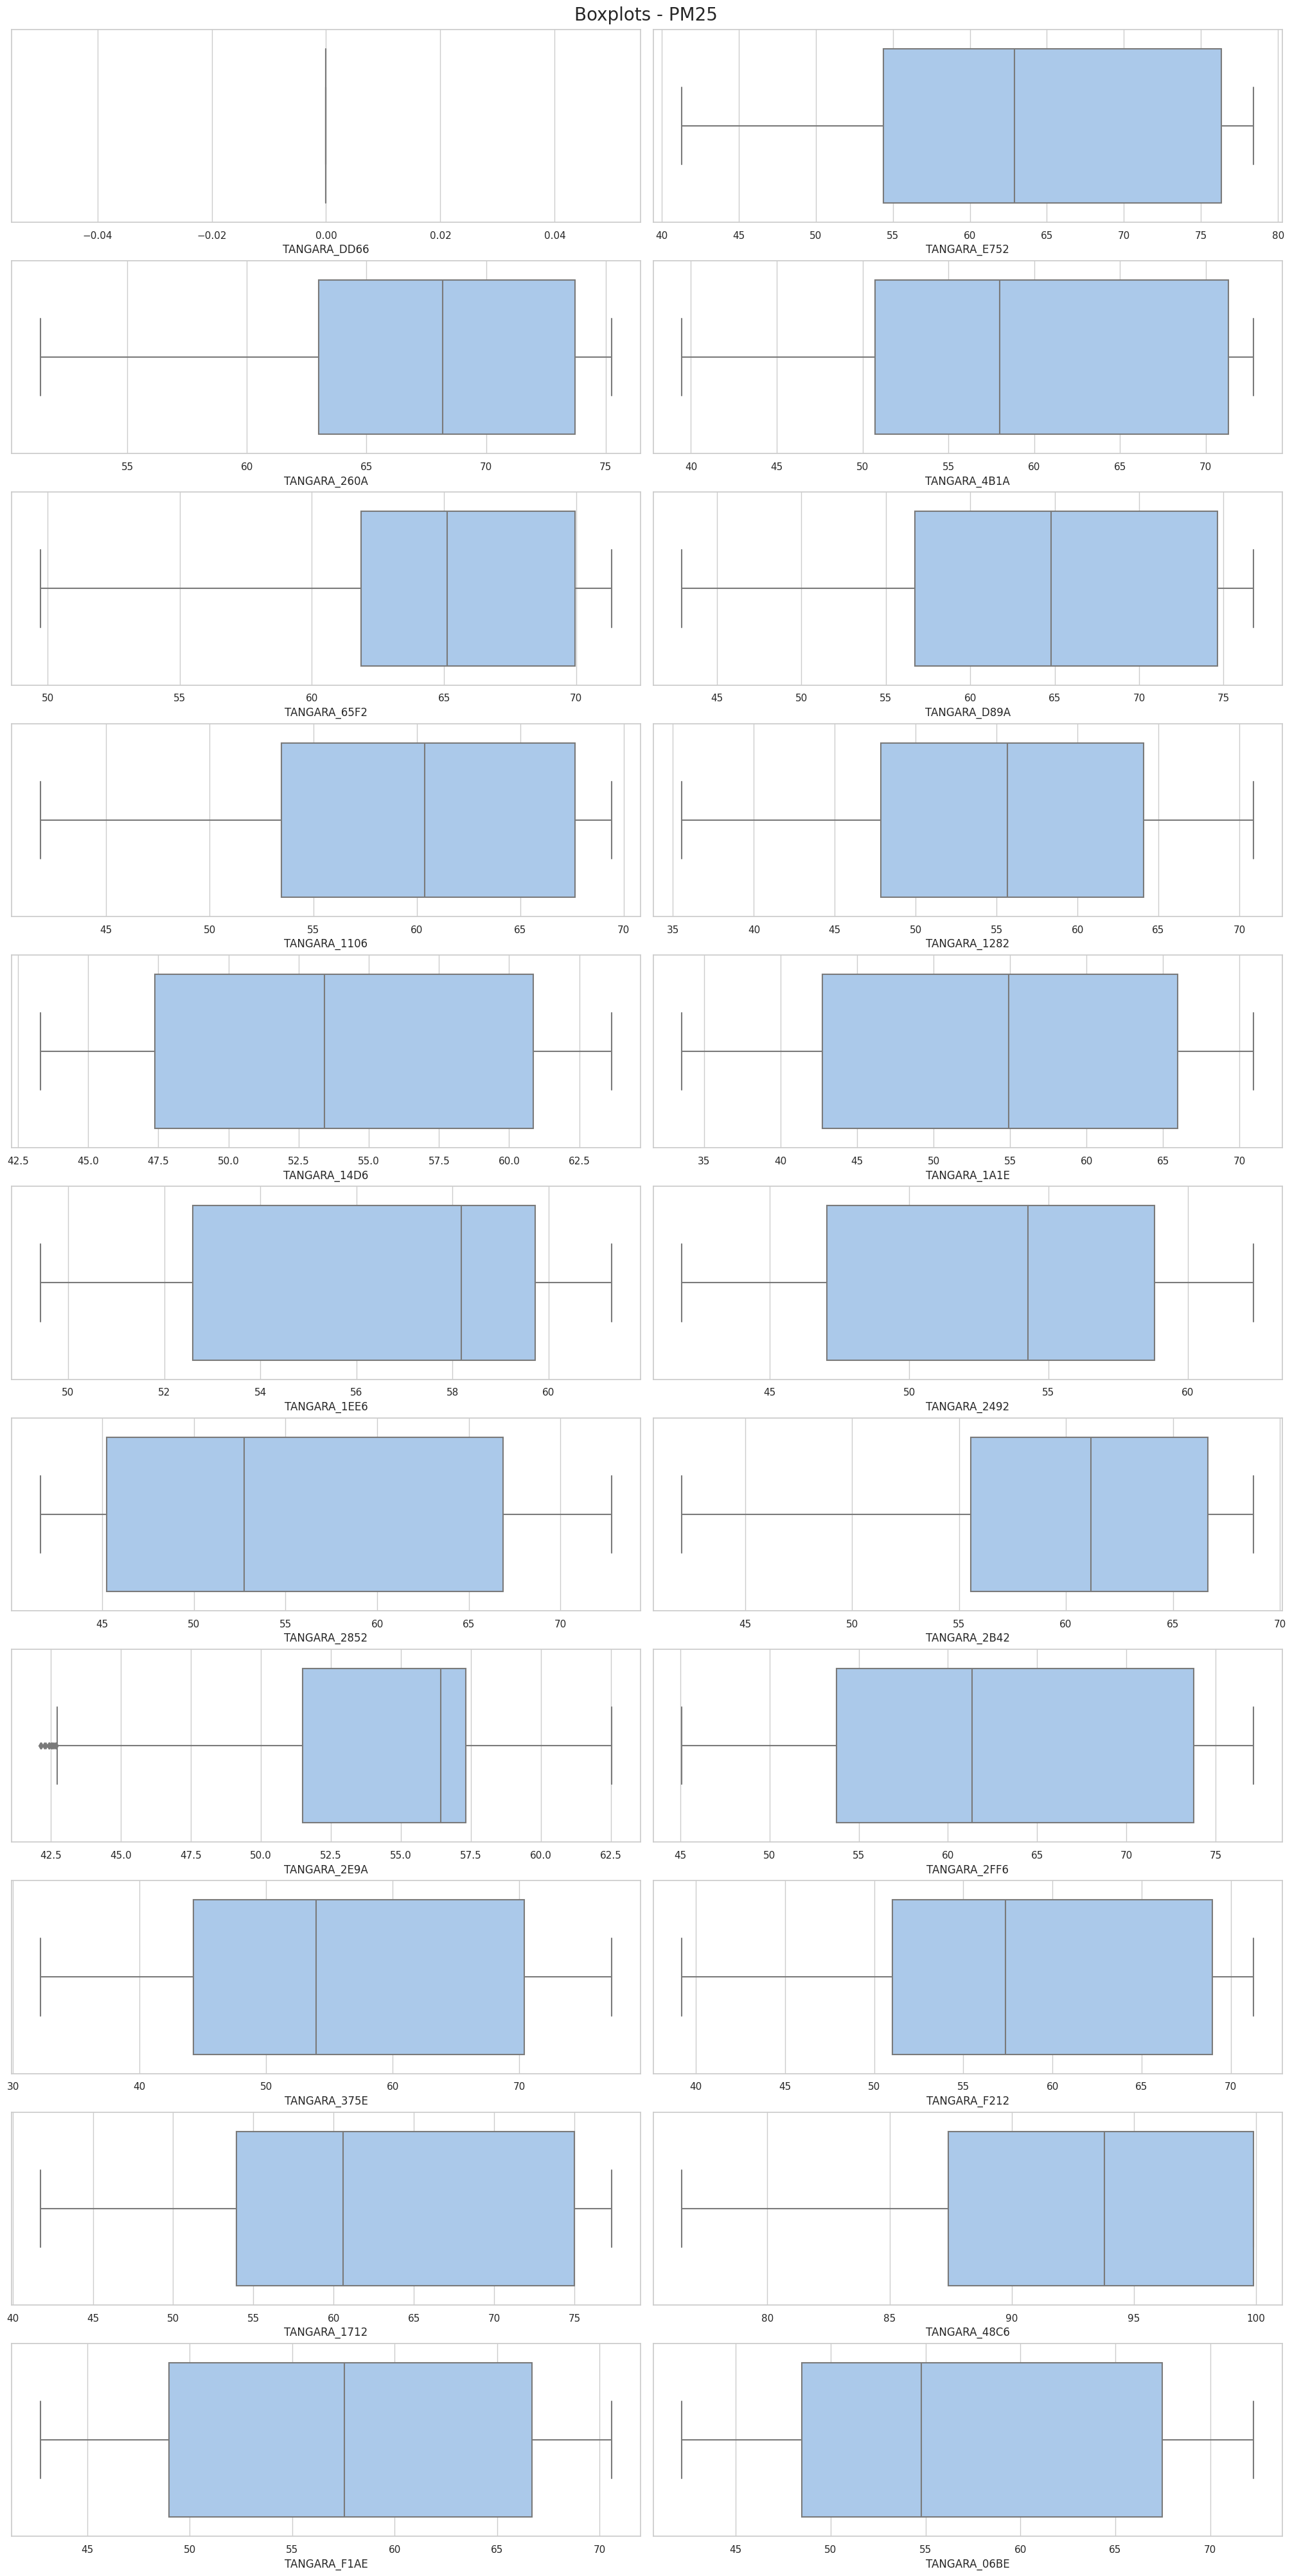

In [9]:
# Plot Humidity Boxplots
boxplots(hum_raw)

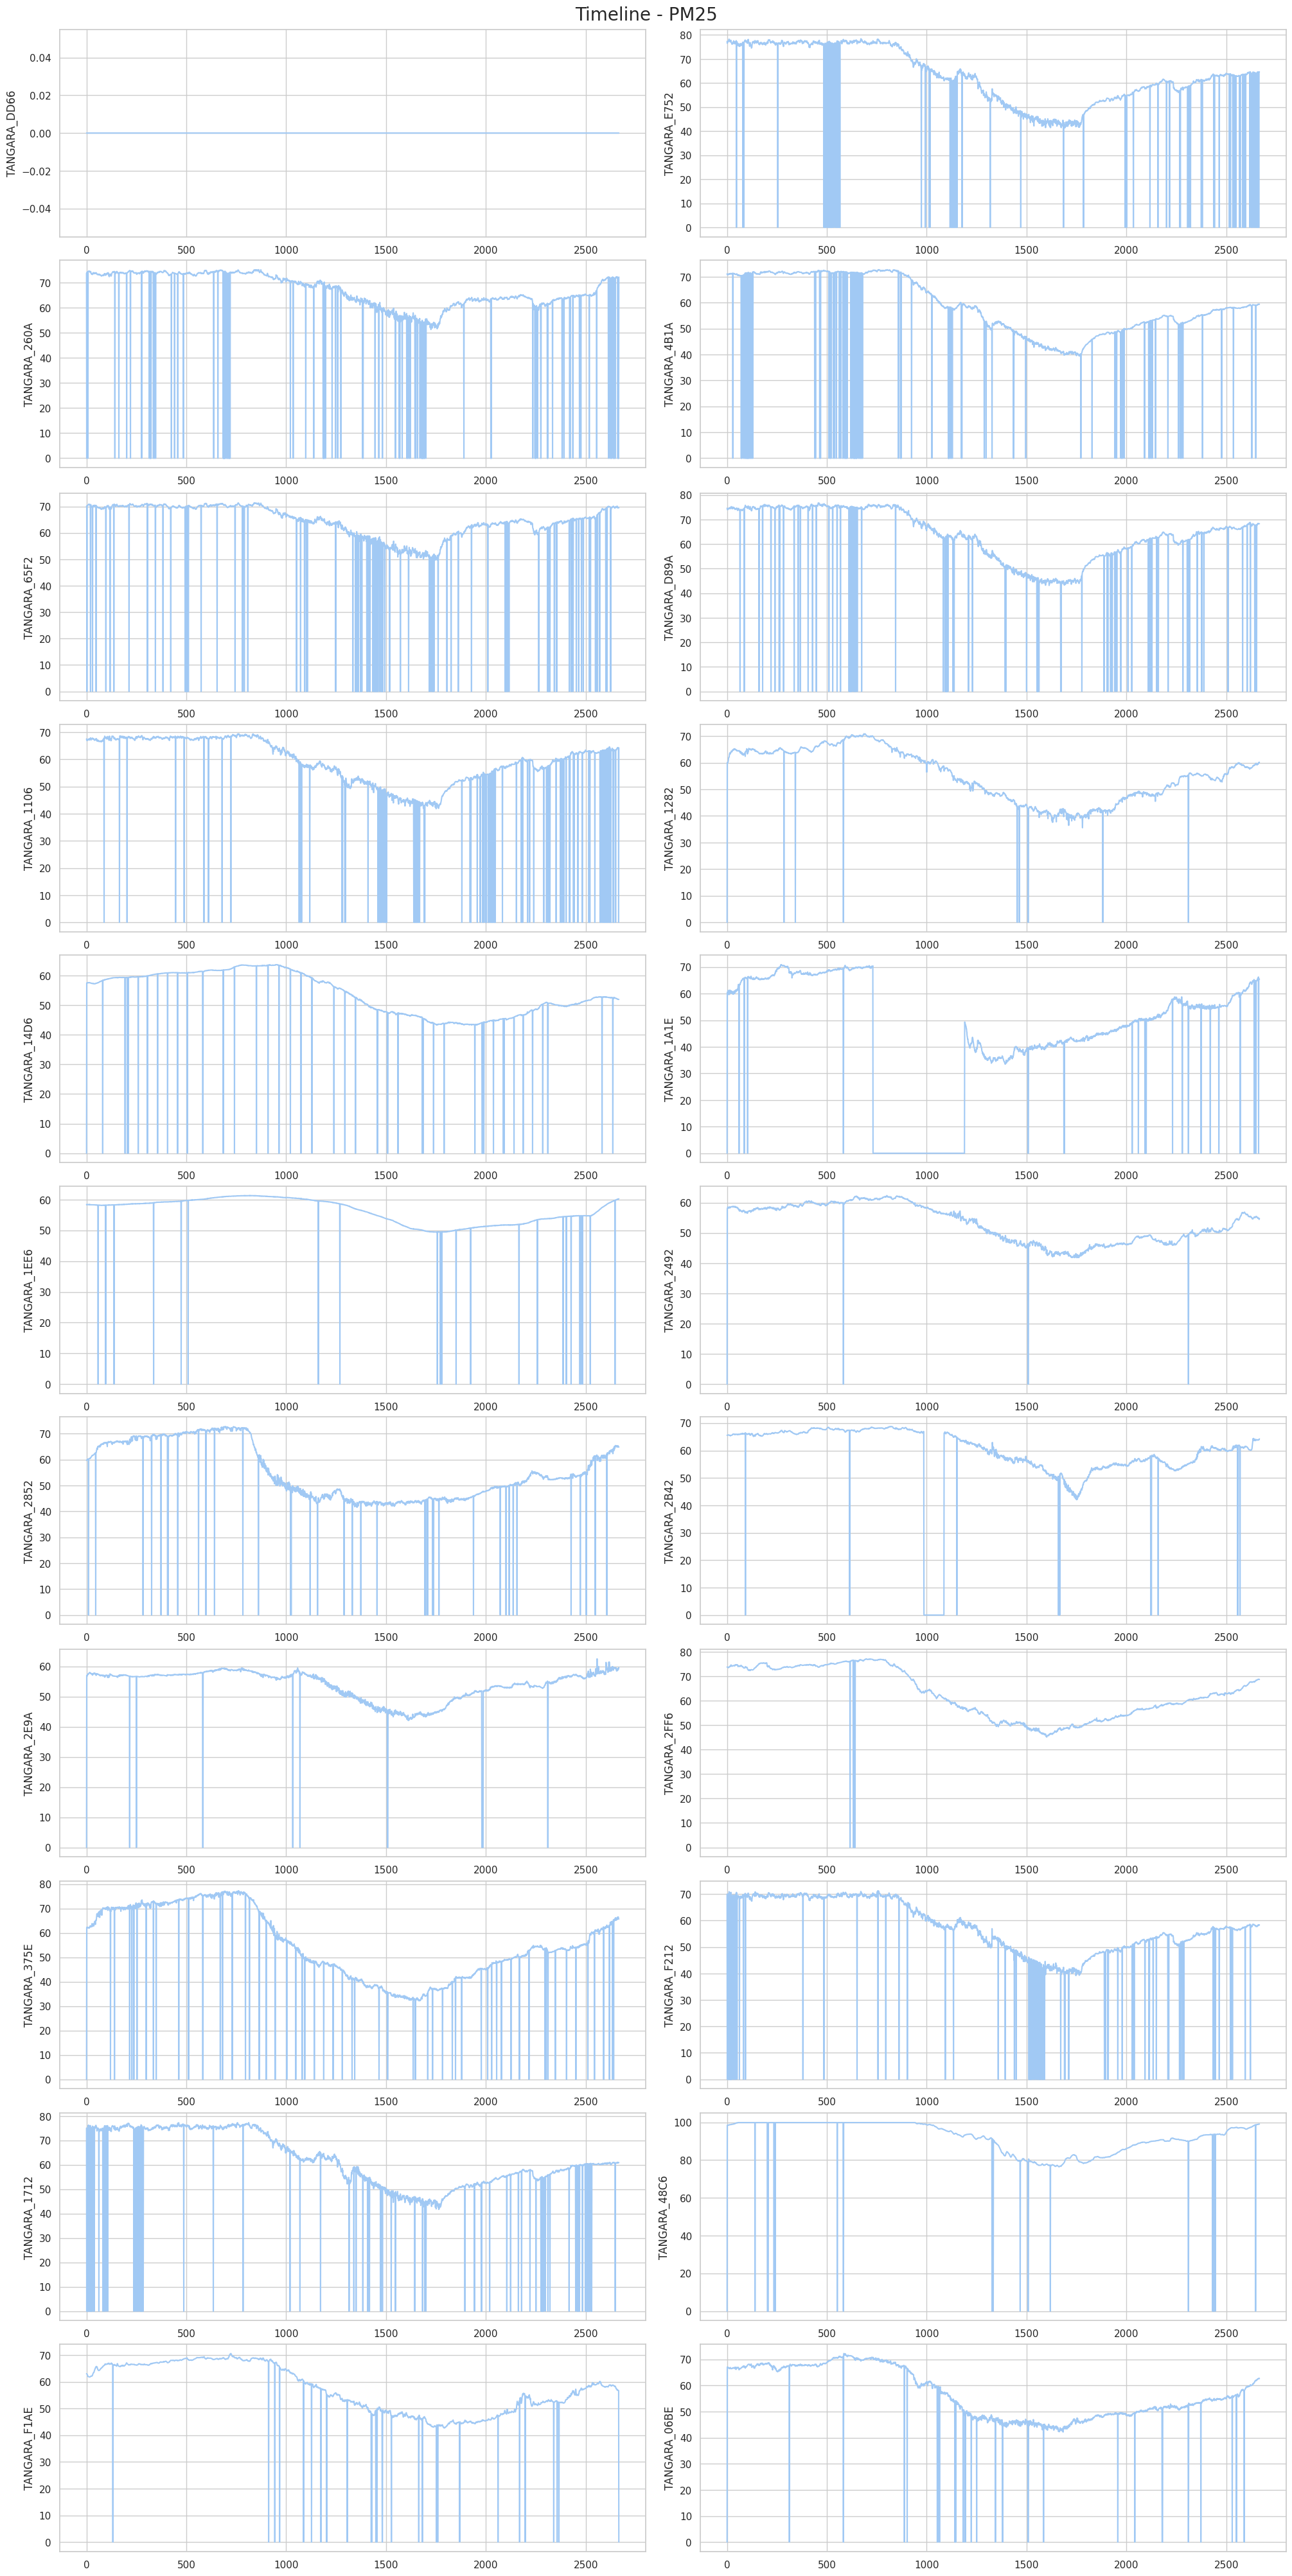

In [10]:
# Plot Humidity Lineplots
lineplots(hum_raw)

In [11]:
# Evaluate Sensors
print(f'Total Sensors: {len(hum_raw.columns[1:])}')
to_be_checked = evaluate_sensors(hum_raw, 85)
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked

Total Sensors: 22
To Be Checked: 1


[{'ID': 'TANGARA_1A1E', 'Data': '82%', 'Missing': '18%'}]

In [11]:
# Save Humidity raw data into CSV file
hum_raw.to_csv('../data/hum_raw.csv', index=False)